In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from helpers.helper_functions import *

# Handling text 2 exercise
[Handling text exercises ADApted from ADA 2018 final exam]

The Sheldon Cooper we all know and love (OK, some of us might not know him, and some might not love him) from the TV series "The Big Bang Theory" has gotten into an argument with Leonard from the same TV show. Sheldon insists that he knows the show better than anyone, and keeps making various claims about the show, which neither of them know how to prove or disprove. The two of them have reached out to you ladies and gentlemen, as data scientists, to help them. You will be given the full script of the series, with information on the episode, the scene, the person saying each dialogue line, and the dialogue lines themselves.

Leonard has challenged several of Sheldon's claims about the show, and throughout this exam you will see some of those and you will get to prove or disprove them, but remember: sometimes, we can neither prove a claim, nor disprove it!

## Task A: Picking up the shovel

**Note: You will use the data you preprocess in this task in all the subsequent ones.**

Our friends' argument concerns the entire show. We have given you a file in the `data/` folder that contains the script of every single episode. New episodes are indicated by '>>', new scenes by '>', and the rest of the lines are dialogue lines. Some lines are said by multiple people (for example, lines indicated by 'All' or 'Together'); **you must discard these lines**, for the sake of simplicity. However, you do not need to do it for Q1 in this task -- you'll take care of it when you solve Q2.

**Q1**. Your first task is to extract all lines of dialogue in each scene and episode, creating a dataframe where each row has the episode and scene where a dialogue line was said, the character who said it, and the line itself. You do not need to extract the proper name of the episode (e.g. episode 1 can appear as "Series 01 Episode 01 - Pilot Episode", and doesn't need to appear as "Pilot Episode"). Then, answer the following question: In total, how many scenes are there in each season? We're not asking about unique scenes; the same location appearing in two episodes counts as two scenes. You can use a Pandas dataframe with a season column and a scene count column as the response.

**Note: The data refers to seasons as "series".**

In [2]:
# Extract lines of dialogue from the script file: all_scripts.txt
# The file is in the format: >> new episode/new season 
# > new scene
# character: line of dialogue
# Create a dataframe where each row has the episode and scene where a dialogue line was said, the character who said it, and the line itself
# The dataframe should have the following columns: season, episode, scene, character, line
season = ""
episode = ""
scene = ""
data = []
with open("data/all_scripts.txt", encoding="utf8") as f: # f is the file handle
    for line in f.readlines():
        line = line[:-1] # remove newline
        if line.startswith(">> "):
            season = int(line[10:12]) # extract season number
            episode = line[3:] # extract episode name
            continue
        if line.startswith("> "):
            scene = line[2:]
            continue
        character, line = line.split(": ", 1) # split line into character and dialogue
        data.append([season, episode, scene, character, line])
lines = pd.DataFrame(data, columns=["Season", "Episode", "Scene", "Character", "Line"])

In [3]:
lines.head()

,Season,Episode,Scene,Character,Line
0,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,So if a photon is directed through a plane wit...
1,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,"Agreed, what’s your point?"
2,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,"There’s no point, I just think it’s a good ide..."
3,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,Excuse me?
4,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Receptionist,Hang on.


In [4]:
# How many scenes are in each season of the show?
lines.groupby(["Season", "Episode", "Scene"]).count().reset_index().groupby("Season").count()[["Scene"]]

,Scene
Season,
1,157
2,205
3,193
4,219
5,198
6,211
7,207
8,191
9,177


**Q2**. Now, let's define two sets of characters: all the characters, and recurrent characters. Recurrent characters are those who appear in more than one episode. For the subsequent sections, you will need to have a list of recurrent characters. Assume that there are no two _named characters_ (i.e. characters who have actual names and aren't referred to generically as "little girl", "grumpy grandpa", etc.) with the same name, i.e. there are no two Sheldons, etc. Generate a list of recurrent characters who have more than 90 dialogue lines in total, and then take a look at the list you have. If you've done this correctly, you should have a list of 20 names. However, one of these is clearly not a recurrent character. Manually remove that one, and print out your list of recurrent characters. To remove that character, pay attention to the _named character_ assumption we gave you earlier on. **For all the subsequent questions, you must only keep the dialogue lines said by the recurrent characters in your list.**

In [6]:
# Get recurrent characters = appearing in more than one episode and having more than 90 lines of dialogue:
# 1. Count the number of lines of dialogue for each character
# 2. Count the number of episodes for each character
# 3. Merge the two dataframes
# 4. Filter the dataframe to keep only characters appearing in more than one episode and having more than 90 lines of dialogue
recurrent = lines.groupby("Character").count()[["Line"]].reset_index().merge(lines.groupby("Character").nunique()[["Episode"]].reset_index(), on="Character").query("Episode > 1 and Line > 90").reset_index(drop=True).set_index(["Character"])
print("Number of recurrent characters:", len(recurrent))
recurrent.drop("Man", axis=0, inplace=True)
recurrent

Number of recurrent characters: 20


,Line,Episode
Character,,
Amy,3472,154
Arthur,130,4
Bernadette,2690,161
Bert,95,6
Beverley,162,5
Emily,164,17
Howard,5872,231
Kripke,106,8
Leonard,9829,231


## Task B: Read the scripts carefully

### Part 1: Don't put the shovel down just yet

**Q3**. From each dialogue line, replace punctuation marks (listed in the EXCLUDE_CHARS variable provided in `helpers/helper_functions.py`) with whitespaces, and lowercase all the text. **Do not remove any stopwords, leave them be for all the questions in this task.**

In [7]:
def replace_punctuation(x, EXCLUDE_CHARS):
    for c in EXCLUDE_CHARS:
        x = x.replace(c, " ")
    return x

In [8]:
# From each dialogue line, replace punctuation marks listed in the EXCLUDE_CHARS variable provided in helpers/helper_functions.py with whitespaces, and lowercase all the text:
# 1. Create a function that takes a string as input and returns the string with the punctuation marks replaced by whitespaces
# 2. Apply the function to the "Line" column of the dataframe
# 3. Lowercase all the text
lines["Line"] = lines["Line"].apply(lambda x: replace_punctuation(x, EXCLUDE_CHARS)).str.lower()
lines.head()

,Season,Episode,Scene,Character,Line
0,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,so if a photon is directed through a plane wit...
1,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,agreed what s your point
2,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Sheldon,there s no point i just think it s a good ide...
3,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Leonard,excuse me
4,1,Series 01 Episode 01 – Pilot Episode,A corridor at a sperm bank.,Receptionist,hang on


**Q4**. For each term, calculate its "corpus frequency", i.e. its number of occurrences in the entire series. Visualize the distribution of corpus frequency using a histogram. Explain your observations. What are the appropriate x and y scales for this plot?

In [9]:
# Number of words over the entire dialogue lines:
len(lines["Line"].str.cat(sep=" ").split(" "))

757623

In [10]:
# Find all the dialogue lines containing the word "yeah":
# 1. Create a function that takes a string as input and returns True if the string contains the word "yeah" and False otherwise
# 2. Apply the function to the "Line" column of the dataframe
# 3. Filter the dataframe to keep only the rows where the function returns True
def find_yeah(x):
    return "yeah" in x.split(" ")
lines[lines["Line"].apply(find_yeah)]

,Season,Episode,Scene,Character,Line
100,1,Series 01 Episode 01 – Pilot Episode,Sheldon and Leonard’s apartment.,Sheldon,yeah well it s just some quantum mechanics ...
102,1,Series 01 Episode 01 – Pilot Episode,Sheldon and Leonard’s apartment.,Sheldon,yeah
137,1,Series 01 Episode 01 – Pilot Episode,Sheldon and Leonard’s apartment.,Leonard,yeah it s like regular boggle but in klingon...
142,1,Series 01 Episode 01 – Pilot Episode,Sheldon and Leonard’s apartment.,Penny,oh yeah a lot of people think i m a water si...
145,1,Series 01 Episode 01 – Pilot Episode,Sheldon and Leonard’s apartment.,Penny,oh yeah i m a waitress at the cheesecake fac...
...,...,...,...,...,...
51158,10,Series 10 Episode 24 – The Long Distance Disso...,The apartment.,Bernadette,yeah but you re gonna be back in three months
51163,10,Series 10 Episode 24 – The Long Distance Disso...,The apartment.,Amy,yeah but one of those scientists is a tall b...
51195,10,Series 10 Episode 24 – The Long Distance Disso...,The apartment.,Leonard,yeah she s definitely going after sheldon
51198,10,Series 10 Episode 24 – The Long Distance Disso...,The apartment.,Bernadette,yeah there s a million reasons a woman would ...


In [11]:
# Count the number of occurrences of "yeah":
# 1. Create a function that takes a string as input and returns the number of times the word "yeah" appears in the string
# 2. Apply the function to the "Line" column of the dataframe
# 3. Sum the values of the resulting series
def count_yeah(x):
    return x.split(" ").count("yeah")
lines["Line"].apply(count_yeah).sum()

2373

<AxesSubplot:>

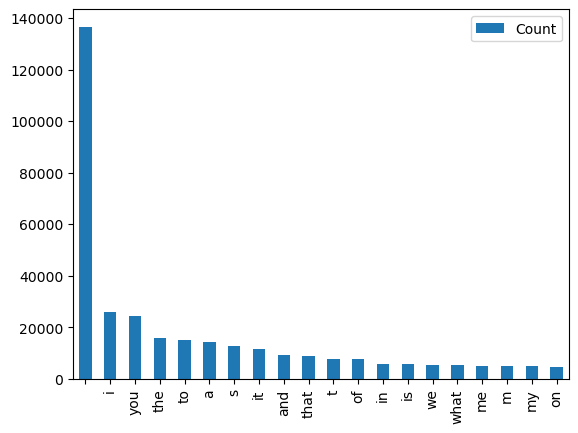

In [12]:
# 1. Create a single string list with all the words from all the dialogue lines of the show:
# 2. Create a dictionary where the keys are the words and the values are the number of times the word appears in the list
# 3. Create a dataframe from the dictionary
# 4. Sort the dataframe by the number of occurrences of the words
# 5. Plot the 20 most frequent words
words = lines["Line"].str.cat(sep=" ").split(" ")
word_counts = {}
for word in words:
    if word in word_counts:
        word_counts[word] += 1
    else:
        word_counts[word] = 1
word_counts = pd.DataFrame.from_dict(word_counts, orient="index", columns=["Count"]).sort_values("Count", ascending=False)
word_counts.head(20).plot(kind="bar")

<AxesSubplot:title={'center':'Distribution of corpus frequency'}, ylabel='Frequency'>

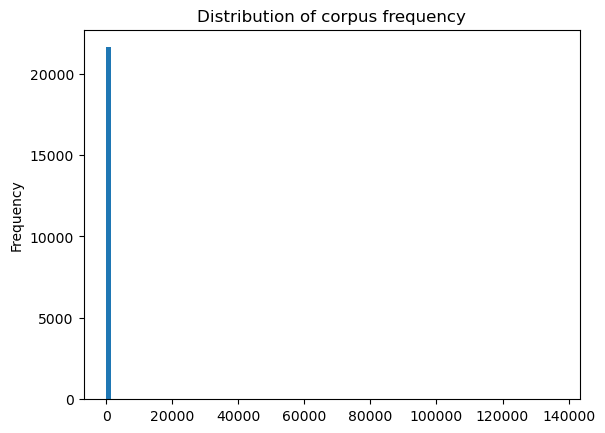

In [17]:
# Visualize the distribution of corpus frequency using a histogram:
word_counts["Count"].plot(kind="hist", bins=100, title = 'Distribution of corpus frequency')

<AxesSubplot:title={'center':'Distribution of corpus frequency (loglog scale)'}, ylabel='Frequency'>

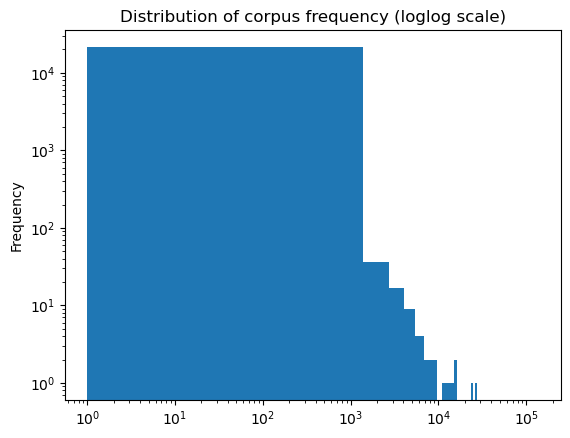

In [21]:
#Plot the distribution of corpus frequency using a loglog scale with a line of best fit:
word_counts["Count"].plot(kind="hist", bins=100, loglog=True, title = 'Distribution of corpus frequency (loglog scale)')
# Plot with bins of equal size in log space:
word_counts["Count"].plot(kind="hist", bins=np.logspace(0, 5, 100), loglog=True, title = 'Distribution of corpus frequency (loglog scale)')

In [111]:
corpus_frequency = pd.concat([pd.Series(row['Line'].split(' ')) for _, row in lines.iterrows()]).reset_index()
corpus_frequency.columns = ["Frequency", "Word"]
corpus_frequency = corpus_frequency.groupby("Word").count()
corpus_frequency

,Frequency
Word,
,136530
0,6
00,5
000,33
000lb,1
...,...
…tion,1
…when,1
…who,1


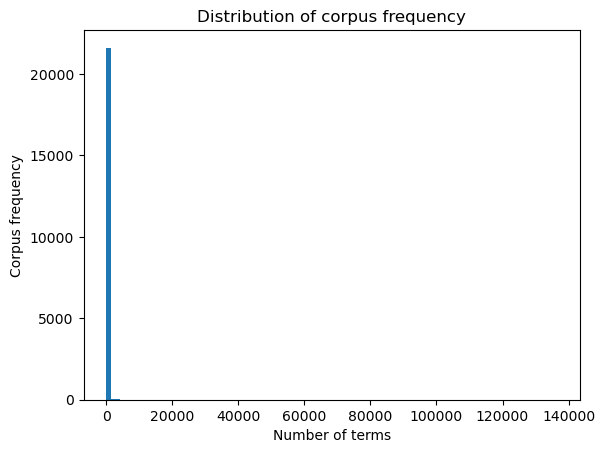

In [116]:
# Visualize the distribution of corpus frequency using a histogram:
# 1. Create a histogram with 100 bins
# 2. Set the x-axis scale to logarithmic
# 3. Set the x-axis label to "Corpus frequency"
# 4. Set the y-axis label to "Number of terms"
# 5. Set the title to "Distribution of corpus frequency"
plt.hist(corpus_frequency["Frequency"], bins=100)
plt.xlabel("Number of terms")
plt.ylabel("Corpus frequency")
plt.title("Distribution of corpus frequency")
plt.show()

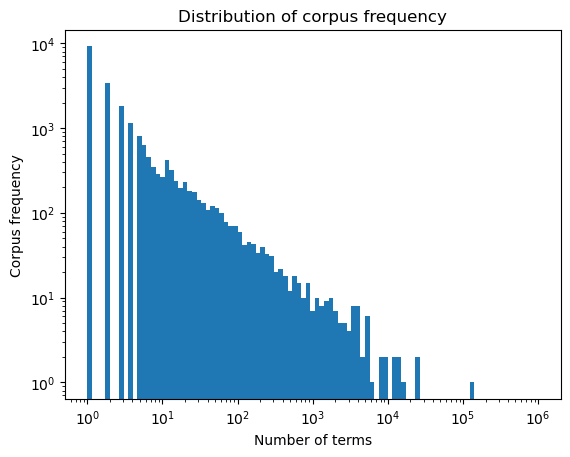

In [119]:
# Visualize the distribution of corpus frequency using a histogram:
# 1. Create a histogram with 100 bins
# 2. Set the x-axis scale to logarithmic
# 3. Set the x-axis label to "Corpus frequency"
# 4. Set the y-axis label to "Number of terms"
# 5. Set the title to "Distribution of corpus frequency"
plt.hist(corpus_frequency["Frequency"], bins= np.logspace(0, 6, 100)) 
# bins = np.logspace(0, 6, 100) to have logarithmic bins meaning that the bins are not equally spaced but the difference between the bins is logarithmic (the difference between the bins is the same for each bin) 
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of terms")
plt.ylabel("Corpus frequency")
plt.title("Distribution of corpus frequency")
plt.show()

The distribution of frequencies follows a power law. The correct way to visualize this frequency is on a log-log scale.

### Part 2: Talkativity
**Q5**. For each of the recurrent characters, calculate their total number of words uttered across all episodes. Based on this, who seems to be the most talkative character?

In [126]:
# For each the characters in the dataframe "recurrent", compute the number of words they use across all episodes:
# 1. Create a function that takes a string as input and returns the number of words in the string
# 2. Apply the function to the "Line" column of the dataframe
# 3. Group the dataframe by "Character" and sum the values of the resulting series
# 4. Sort the values in descending order
recurrent["Number of words"] = lines.groupby("Character").apply(lambda x: x["Line"].apply(lambda x: len(x.split())).sum()).sort_values(ascending=False)
recurrent
# Why does the result change when we use the function len(x.split()) instead of len(x.split(" ")) ???

,Line,Episode,Number of words
Character,,,
Amy,3472,154,39933
Arthur,130,4,1451
Bernadette,2690,161,27726
Bert,95,6,1146
Beverley,162,5,2029
Emily,164,17,1571
Howard,5872,231,69505
Kripke,106,8,1246
Leonard,9829,231,102496


In [125]:
print("Most talkative character: ", recurrent["Number of words"].idxmax()) #idxmax: returns index of the max value ! 

Most talkative character:  Sheldon


## Task D: The Detective's Hat

Sheldon claims that given a dialogue line, he can, with an accuracy of above 70%, say whether it's by himself or by someone else. Leonard contests this claim, since he believes that this claimed accuracy is too high.

**Q6**. Divide the set of all dialogue lines into two subsets: the training set, consisting of all the seasons except the last two, and the test set, consisting of the last two seasons.

In [130]:
# Divide the set of all dialogue lines into two subsets: the training set, consisting of all the seasons except the last two, and the test set, consisting of the last two seasons:
# 1. Create a list of the season numbers
# 2. Create a list of the last two season numbers
# 3. Create a function that takes a string as input and returns True if the string is in the list of the last two season numbers and False otherwise
# 4. Apply the function to the "Season" column of the dataframe
# 5. Filter the dataframe to keep only the rows where the function returns True
# 6. Create a function that takes a string as input and returns True if the string is not in the list of the last two season numbers and False otherwise
# 7. Apply the function to the "Season" column of the dataframe
# 8. Filter the dataframe to keep only the rows where the function returns True
seasons = lines["Season"].unique()
last_two_seasons = seasons[-2:]
def is_last_two_seasons(x):
    return x in last_two_seasons
test = lines[lines["Season"].apply(is_last_two_seasons)]
def is_not_last_two_seasons(x):
    return x not in last_two_seasons
train = lines[lines["Season"].apply(is_not_last_two_seasons)]

**Q7**. Find the set of all words in the training set that are **only** uttered by Sheldon. Is it possible for Sheldon to identify himself only based on these? Use the test set to assess this possibility, and explain your method.

In [214]:
# Find the set of all words in the training set that are ONLY uttered by Sheldon and not by other characters: 
words_for_chars = pd.concat([pd.Series(row["Character"], row['Line'].split())
                             for _, row in train.iterrows()]).reset_index()
words_for_chars.columns = ["Word", "Character"]

words_for_chars = words_for_chars.groupby("Word")["Character"].apply(set)
sheldon_words = words_for_chars[words_for_chars.apply(lambda x: ("Sheldon" in x) and (len(x) == 1))].index

In [215]:
def contains_sheldon_words(line):
    for word in sheldon_words:
        if word in line.split():
            return True
    return False
test_pred = test["Line"].apply(contains_sheldon_words)
test_true = test["Character"] == "Sheldon"

In [216]:
# Compute the accuracy of the classifier:
print("Accuracy: ", (test_true == test_pred).sum() / len(test_true))

Accuracy:  0.7825013713658804


We know that a line that contains a word that is only said by Sheldon has to be said by Sheldon. Our simple classifier classifies such lines as uttered by Sheldon, and other lines as not uttered by Sheldon. This results in an accuracy of 78% on the test set.

To build our classifier, we need to isolate the words that are only said by Sheldon, (`sheldon_words`), by first associating each word in the line to the character that uttered the line, then grouping by words and keeping only the ones that contain only "Sheldon" as `Character`.